In [1]:
from d2l import torch as d2l
import torch
from torch import nn

batch_size, num_steps = 32,35
train_iter, vocab = d2l.load_data_time_machine(batch_size,num_steps)

In [2]:
def get_lstm_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size
    #初始化权重w 服从高斯分布 0.01偏差
    def normal(shape):
        return torch.randn(size=shape,device=device)*0.01
    def three():
        return (normal((num_inputs,num_hiddens)),
                normal((num_inputs,num_hiddens)),
                torch.zeros(num_hiddens,device=device))

    W_xi, W_hi, b_i = three() #输入门参数
    W_xf, W_hf, b_f = three() #遗忘门参数
    W_xo, W_ho, b_o = three() #输出门参数
    W_xc, W_hc, b_c = three() #记忆细胞参数 Candidate cell parameters

    #Output layer parameters
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs,device=device)
    #Attach gradients
    params = [W_xi, W_hi, b_i, W_xf, W_hf,b_f,W_xo, W_ho, b_o,W_xc, W_hc, b_c,
              W_hq,b_q]
    for param in params:
        param.requires_grad_(True)# 保留梯度信息为反向传播准备
    return params

In [3]:
#the hidden state of the LSTM needs to return an additional memory cell with a value of  0
# and a shape of (batch size, number of hidden units)
def init_lstm_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size,num_hiddens),device=device),
            torch.zeros((batch_size,num_hiddens),device=device))

In [4]:
def lstm(inputs, state, params):
    [W_xi, W_hi, b_i, W_xf, W_hf,b_f,W_xo, W_ho, b_o,W_xc, W_hc, b_c,
              W_hq,b_q] = params
    (H, C) = state
    outputs = []
    for X in inputs:
        I = torch.sigmoid((X @ W_xi) + (H @ W_hi) + b_i)
        F = torch.sigmoid((X @ W_xf) + (H @ W_hf) + b_f)
        O = torch.sigmoid((X @ W_xo) + (H @ W_ho) + b_o)
        C_tilda = torch.tanh((X @ W_xc) + (H @ W_hc) + b_c)
        C = F * C + I * C_tilda
        H = O * torch.tanh(C)
        Y = (H @ W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs,dim=0), (H, C)

RuntimeError: mat1 dim 1 must match mat2 dim 0

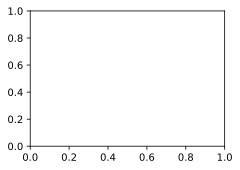

In [5]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = d2l.RNNModelScratch(len(vocab),num_hiddens,device,get_lstm_params,
                            init_lstm_state, lstm)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)